# Trading Robot

**Introduccion**

---

**Robot Trading en Python** capaz de tomar decisiones de compra y venta de Bitcoin en tiempo real.

## Prepariacion de proyecto

### Librerias

In [35]:
import pandas as pd
import numpy as np
import matplotlib as plt
from functions import *
import yfinance
from bs4 import BeautifulSoup
import requests

### Versiones

In [36]:
!python -V
print('------')
!pip show Pandas
print('------')
!pip show Numpy
print('------')
!pip show Matplotlib 

Python 3.9.18
------
Name: pandas
Version: 2.1.1
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: https://pandas.pydata.org
Author: 
Author-email: The Pandas Development Team <pandas-dev@python.org>
License: BSD 3-Clause License
        
        Copyright (c) 2008-2011, AQR Capital Management, LLC, Lambda Foundry, Inc. and PyData Development Team
        All rights reserved.
        
        Copyright (c) 2011-2023, Open source contributors.
        
        Redistribution and use in source and binary forms, with or without
        modification, are permitted provided that the following conditions are met:
        
        * Redistributions of source code must retain the above copyright notice, this
          list of conditions and the following disclaimer.
        
        * Redistributions in binary form must reproduce the above copyright notice,
          this list of conditions and the following disclaimer in the documentation
          an

Name: matplotlib
Version: 3.8.0
Summary: Python plotting package
Home-page: https://matplotlib.org
Author: John D. Hunter, Michael Droettboom
Author-email: matplotlib-users@python.org
License: PSF
Location: c:\users\el_bo\anaconda3\envs\basicpython\lib\site-packages
Requires: contourpy, cycler, fonttools, importlib-resources, kiwisolver, numpy, packaging, pillow, pyparsing, python-dateutil
Required-by: jupyterthemes, seaborn


## Obtencion de datos

### Funciones

In [ ]:
user_agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/117.0.0.0 Safari/537.36"

def example(number):
  return number * 2

#Getting Yahoo! Finance Bitcoin History Data
def importar_base_bitcoin():
  bitcoin = yfinance.Ticker("BTC-USD")
  df_bitcoin = bitcoin.history(period="7d", interval="5m")
  return df_bitcoin

#Getting tendencies from CoinMarket
def extraer_tendencias(url, simbol: str) -> tuple:

  def get_status(row: str) -> str:
    alta_icon = "icon-Caret-up"
    baja_icon = "icon-Caret-down"
    if(alta_icon in row):
      return "alta"
    else:
      return "baja"

  def str_to_float(price: str) -> float:
    return float(price.replace("$", "").replace(",", ""))

  headers = { "User-Agent": user_agent }
  request = requests.get(url, headers)
  web_content = BeautifulSoup(request.content, features="lxml")
  table = web_content.find("table", class_="cmc-table")
  btc_row = []
  for tr in table.tbody:
    p_tags = tr.find_all("p")
    for p in p_tags:
      if(p.string == simbol):
        btc_row.append(tr)
  status_icon_column = str(list(btc_row[0])[4])
  table_stringed = io.StringIO(str(table))
  df_table = pandas.read_html(table_stringed)[0]
  df = df_table[["Name", "Price", "1h %"]]
  status = get_status(status_icon_column)
  df_bitcoin_row = df.loc[df["Name"] == "BitcoinBTC"].copy()
  df_bitcoin_row["Status"] = status
  price = str_to_float(str(df_bitcoin_row["Price"][0]))
  return ( price, status )


Ejemplo

In [ ]:
extraer_tendencias(url, 'BTC')

Variables Globales

In [37]:
global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision

## Limpieza de datos

**Limpieza de datos**

Crea una funcion ```limpieza_datos()```, dentro de ella, define nuevamente las variables globales(ver Paso1) y escribe tu código:

Antes de limpiar la base, crea una copia de la base ``df_bitcoin`` para que realices la limpieza en esta nueva base(``df_bitcoin_limpio``), sin modificar la base original, además es importante entender su contenido:

- ``Datetime``: Es el índice del dataframe, y contiene la fecha y hora del intervalo seleccionado, no puede estar duplicado.

- ``Open``: Contiene el precio del Bitcoin al inicio del intervalo.

- ``High``: Contiene el precio más alto del Bitcoin durante el intervalo.

- ``Low``: Contiene el precio más bajo del Bitcoin durante el intervalo.

- ``Close``: Contiene el precio del Bitcoin al final del intervalo.

- ``Volume``: Contiene el total de transacciones hechas durante el intervalo.

Para la limpieza utilizaremos los atributos `Datetime, Close y Volume`.

- Analiza la base ``df_bitcoin_limpio``, identifica duplicados en el índice y trátalos para quedarte con sólo índices únicos.
- Luego busca por valores nulos en la columna ``Close`` y trátalos.
- Verifica que todos los registros de la base tengan un ``Volume`` de transacción mayor a 0, caso contrário, elimínalos.
- Deberás identificar y eliminar los outliers en el precio del Bitcoin, columna ``Close``, utiliza un gráfico de boxplot para identificarlos.
- Filtra o selecciona únicamente los registros cuyo precio(``Close``) se encuentren entre el 1er cuartil(``Q1``) y el 3er cuartil(``Q3``) del boxplot.
- Finalmente, calcula el precio promedio(``Close``) de esta selección y guárdala en la variable ``media_bitcoin``.

**Importando datos en un data frame**

---

In [38]:
df_bitcoin = importar_base_bitcoin()

**Copia del data frame**

---

In [ ]:
df_bitcoin_limpio = df.copy()

### Exploracion de datos

Investigando el shape del datframe

In [39]:
df_bitcoin_limpio.shape

(1015, 7)

In [40]:
df_bitcoin.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-10-08 00:00:00+00:00,27971.677734,27974.541016,27970.494141,27970.734375,0,0.0,0.0
2023-10-08 00:05:00+00:00,27967.513672,27975.888672,27967.513672,27975.650391,0,0.0,0.0
2023-10-08 00:10:00+00:00,27978.839844,27978.839844,27977.730469,27977.730469,0,0.0,0.0
2023-10-08 00:15:00+00:00,27979.955078,27979.955078,27972.322266,27973.787109,0,0.0,0.0
2023-10-08 00:20:00+00:00,27975.755859,27981.078125,27975.755859,27977.574219,0,0.0,0.0


In [41]:
df_bitcoin_limpio.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1015 entries, 2023-10-08 01:35:00+00:00 to 2023-10-14 19:45:00+00:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1015 non-null   float64
 1   High          1015 non-null   float64
 2   Low           1015 non-null   float64
 3   Close         1015 non-null   float64
 4   Volume        1015 non-null   int64  
 5   Dividends     1015 non-null   float64
 6   Stock Splits  1015 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 63.4 KB


---

Observamos 6 variales float y 1 int, estamos trabajando en su totalidad con variables numericas, lo que representa algo bueno para el modelo a realizar. No tenemos valores nulos en el dataframe

---

#### Eliminar duplicados

Drop Duplicates, eliminamos duplicados en el dataframe

In [42]:
df_bitcoin_limpio.drop_duplicates()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-10-08 01:35:00+00:00,27967.505859,27981.777344,27967.505859,27981.777344,672768,0.0,0.0
2023-10-08 01:40:00+00:00,27998.867188,28006.935547,27998.867188,28006.935547,8745984,0.0,0.0
2023-10-08 01:45:00+00:00,28023.980469,28025.269531,28011.816406,28025.269531,30200320,0.0,0.0
2023-10-08 01:50:00+00:00,28027.230469,28031.132812,28018.419922,28018.419922,3132928,0.0,0.0
2023-10-08 01:55:00+00:00,28018.630859,28018.630859,28016.408203,28017.728516,4307456,0.0,0.0
...,...,...,...,...,...,...,...
2023-10-14 19:25:00+00:00,26876.623047,26877.767578,26875.000000,26876.720703,8607744,0.0,0.0
2023-10-14 19:30:00+00:00,26877.585938,26878.345703,26876.923828,26878.345703,6729728,0.0,0.0
2023-10-14 19:35:00+00:00,26872.228516,26876.076172,26868.685547,26870.087891,5064192,0.0,0.0


#### Eliminar valores de los registros que tienen un ``Volume`` de transacción menor e igual a 0

In [43]:
#Función `query` para filtrar los registros con "Volume" mayor a 0.

df_bitcoin_limpio = df_bitcoin_limpio.query("Volume > 0")

# Esto eliminará todos los registros en los que "Volume" sea igual o menor a 0.

In [44]:
df_bitcoin_limpio.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1015 entries, 2023-10-08 01:35:00+00:00 to 2023-10-14 19:45:00+00:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1015 non-null   float64
 1   High          1015 non-null   float64
 2   Low           1015 non-null   float64
 3   Close         1015 non-null   float64
 4   Volume        1015 non-null   int64  
 5   Dividends     1015 non-null   float64
 6   Stock Splits  1015 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 63.4 KB


#### Busqueda de valores nulos en la columna Close y trátalos.

In [60]:
# Buscar valores nulos en la columna "Close"
valores_nulos = df_bitcoin_limpio['Close'].isnull()

# Contar la cantidad de valores nulos
cantidad_valores_nulos = valores_nulos.sum()

if cantidad_valores_nulos > 0:
    
    # Si hay valores nulos, puedes optar por eliminar las filas con valores nulos o llenarlos con un valor específico, como el promedio.
    
    # Por ejemplo, para eliminar las filas con valores nulos:
    
    df_bitcoin_limpio = df_bitcoin_limpio[~valores_nulos]
    
    # Lenarlos con el precio promedio:
    
#     df_bitcoin_limpio['Close'].fillna(media_bitcoin, inplace=True)
    
    print(f"Se encontraron {cantidad_valores_nulos} valores nulos en la columna 'Close' y se han tratado según tu elección.")
else:
    print("No se encontraron valores nulos en la columna 'Close'.")


No se encontraron valores nulos en la columna 'Close'.


In [45]:
df_bitcoin_limpio.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-10-08 01:35:00+00:00,27967.505859,27981.777344,27967.505859,27981.777344,672768,0.0,0.0
2023-10-08 01:40:00+00:00,27998.867188,28006.935547,27998.867188,28006.935547,8745984,0.0,0.0
2023-10-08 01:45:00+00:00,28023.980469,28025.269531,28011.816406,28025.269531,30200320,0.0,0.0
2023-10-08 01:50:00+00:00,28027.230469,28031.132812,28018.419922,28018.419922,3132928,0.0,0.0
2023-10-08 01:55:00+00:00,28018.630859,28018.630859,28016.408203,28017.728516,4307456,0.0,0.0


#### Identificar y eliminar los outliers en el precio del Bitcoin, columna ``Close``, gráfico de boxplot para identificarlos.

In [50]:
import matplotlib.pyplot as plt

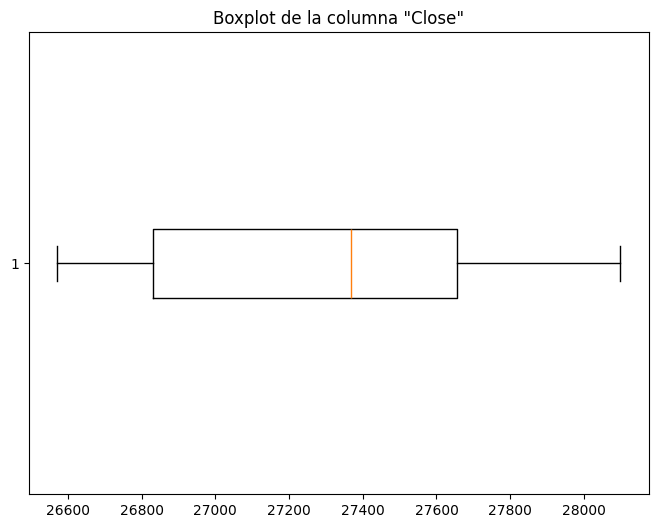

In [53]:
# Crear un boxplot de la columna "Close"
plt.figure(figsize=(8, 6))
plt.boxplot(df_bitcoin_limpio['Close'], vert=False)
plt.title('Boxplot de la columna "Close"')
plt.show()

**No se observan outliers.**

#### Filtra únicamente los registros cuyo precio(``Close``) se encuentren entre el 1er cuartil(``Q1``) y el 3er cuartil(``Q3``) del boxplot.

In [54]:
# Calcular los cuartiles Q1 y Q3
Q1 = df_bitcoin_limpio['Close'].quantile(0.25)
Q3 = df_bitcoin_limpio['Close'].quantile(0.75)

# Calcular el rango intercuartílico (IQR)
IQR = Q3 - Q1

# Definir los límites para seleccionar registros
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Filtrar el DataFrame para seleccionar registros dentro del rango
df_filtrada = df_bitcoin_limpio[(df_bitcoin_limpio['Close'] >= lower_limit) & (df_bitcoin_limpio['Close'] <= upper_limit)]


In [56]:
df_filtrada.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1015 entries, 2023-10-08 01:35:00+00:00 to 2023-10-14 19:45:00+00:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1015 non-null   float64
 1   High          1015 non-null   float64
 2   Low           1015 non-null   float64
 3   Close         1015 non-null   float64
 4   Volume        1015 non-null   int64  
 5   Dividends     1015 non-null   float64
 6   Stock Splits  1015 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 63.4 KB


#### Calcular el precio promedio(``Close``) de esta selección y guárdala en la variable media_bitcoin.

In [62]:
# Redondear el precio promedio a dos decimales

media_bitcoin = df_filtrada['Close'].mean()

media_bitcoin = round(media_bitcoin, 2)

# Imprimir el resultado
print("Precio promedio de Bitcoin (Close) en el rango seleccionado:", media_bitcoin)

Precio promedio de Bitcoin (Close) en el rango seleccionado: 27290.85


---

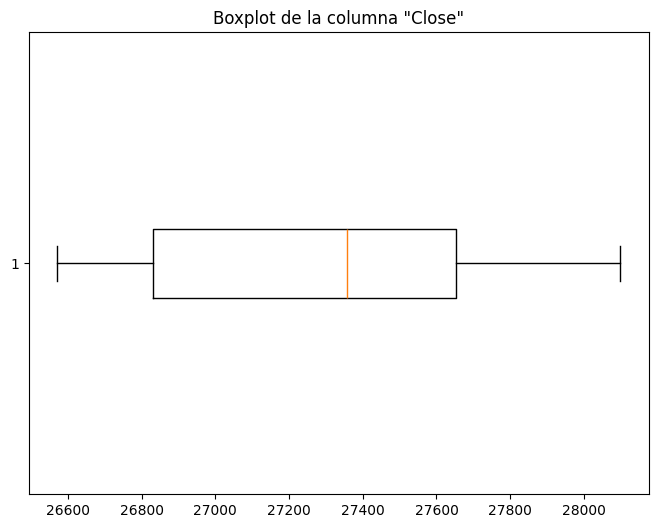

Limpieza de datos completada.


In [66]:
def limpieza_datos():
    global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision
    
    # Crear una copia de la base de datos para la limpieza
    df_bitcoin_limpio = df_bitcoin.copy()
    
    # Eliminar duplicados en el índice
    df_bitcoin_limpio = df_bitcoin_limpio[~df_bitcoin_limpio.index.duplicated(keep='first')]
    
    # Buscar valores nulos en la columna "Close" y eliminarlos
    df_bitcoin_limpio.dropna(subset=['Close'], inplace=True)
    
    # Verificar que todos los registros tengan un Volume de transacción mayor a 0
    df_bitcoin_limpio = df_bitcoin_limpio[df_bitcoin_limpio['Volume'] > 0]
    
    # Identificar y eliminar outliers en la columna "Close" usando un boxplot
    plt.figure(figsize=(8, 6))
    plt.boxplot(df_bitcoin_limpio['Close'], vert=False)
    plt.title('Boxplot de la columna "Close"')
    plt.show()
    
    Q1 = df_bitcoin_limpio['Close'].quantile(0.25)
    Q3 = df_bitcoin_limpio['Close'].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    
    df_bitcoin_limpio = df_bitcoin_limpio[(df_bitcoin_limpio['Close'] >= lower_limit) & (df_bitcoin_limpio['Close'] <= upper_limit)]
    
    # Calcular el precio promedio (Close) de esta selección
    media_bitcoin = df_bitcoin_limpio['Close'].mean()
    
    print("Limpieza de datos completada.")

# Llamar a la función para realizar la limpieza de datos
limpieza_datos()